# Задание № 3

## Описание данных

Предоставлена выгрузка из рекламного кабинета (dataset_task3), который содержит
- Месяц
- Название рекламной кампании
- № рекламной кампании
- Кол-во показов рекламного объявления
- Средняя позиция показа рекламного объявления

**Задача** - нарисовать слайд для отчетной презентации перед руководством, который иллюстрирует результаты маркетологов в части повышения видимости рекламы.

Основная информация на слайде будет состоять из % показов рекламного объявления на позиции ТОП-1 и ТОП-3 для:
- брендовых рекламных кампаний
- не брендовых рекламных кампаний
- общий для всех рекламных кампаний

Определить тип кампании можно по наличию brand в названии кампании.  
Позиции для показа рекламного объявления в поисковой выдачи ограничены рядом целых чисел от 1 до 8.

In [1]:
import pandas as pd
from scipy.stats import poisson
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# стартовые данные
pos_min = 1
pos_max = 8
pos_list = [x for x in range(pos_min, pos_max + 1)]

In [3]:
# чтение файла
data = pd.read_excel('dataset_task3.xlsx')

pd.set_option('display.max_colwidth', None) # значения в столбце 'Кампания' показываем полностью
data.head()

,Дата,Кампания,№ Кампании,Показы,Ср. позиция показов
0,янв 2022,o-a_corporate_perform_god_20220100016_context_search_brand_srb_yxprrko,69149644,4442,1.10
1,янв 2022,o-a_corporate_perform_god_20220100016_context_search_brand_url_yxprrko,69149675,2692,1.04
2,янв 2022,o-a_corporate_perform_god_20220100016_context_search_brand_cch_yxprrko,69149701,1382,1.06
3,янв 2022,o-a_corporate_perform_god_20220100016_context_search_general_szb_yxprrko,69149723,9006,1.24
4,янв 2022,o-a_corporate_perform_god_20220100016_context_search_brand_msk_yxprrko,69149760,7365,1.24


## Предобработка данных

In [4]:
# добавляем столбец с обозначением типа кампании (брендовая / не-брендовая)

def campany(data):
    
    '''
     возвращает значение 'brand', если в названии кампании присутсвует слово 'brand'
     и значение 'no-brand' в остальных случаях.
    '''
    if '_brand_' in data:
        return 'brand'
    return 'no-brand'

data['Тип_кампании'] = data['Кампания'].apply(campany)

In [5]:
# описываем функцию, в которой на выходе получаем список с распределением процентов по позициям показов

def pois(mu, size, min, max, pos_list):
    
    '''
     генерим случайные значения позиций показов из распределения Пуассона с заданным средним значением ('Ср. позиция показов')
     и заданным размером выборки ('Показы'). Увеличиваем количество показов в `times_larger` раз, для того, чтобы
     из полученного количества можно было выбрать заданное количество показов в нужном интервале (1-8 позиции).
    '''
    times_larger = 2
    sample = poisson.rvs(mu=mu, size = size * times_larger)
    
    # выбираем из сгенерированной выборки значения, попадающие в нужный диапазон
    sample_in_range = []
    for value in sample:
        if value >= min and value <= max:
            sample_in_range.append(value)   
        if len(sample_in_range) >= size:
            break
    
    # считаем проценты для позиций показов
    result = []    
    for pos in pos_list:
        result.append(len([x for x in sample_in_range if x == pos])/len(sample_in_range))
    
    return result

In [6]:
# добавляем столбцы Топ_1 и Топ_3 с количеством показов

def add_tops(s):
    p = pois(s['Ср. позиция показов'], s['Показы'], pos_min, pos_max, pos_list)
    s['Топ_1'] = p[0] * s['Показы']
    s['Топ_3'] = sum(p[0:3]) * s['Показы']
    return s

data = data.apply(add_tops, axis=1)

In [7]:
# группируем таблицу по типу кампании и дате

data_grouped = (
    data
    .groupby(['Тип_кампании', 'Дата'], as_index=False)
    .agg({'Показы': 'sum', 'Топ_1': 'sum', 'Топ_3': 'sum'})
    .sort_values(by='Дата', ascending=False)
    .reset_index(drop=True)
)

In [8]:
# группируем созданную таблицу по дате

data_totals = (
    data_grouped
    .groupby('Дата', as_index=False)
    .agg({'Показы': 'sum', 'Топ_1': 'sum', 'Топ_3': 'sum'})
    .sort_values(by='Дата', ascending=False)
    .reset_index(drop=True)
)

In [9]:
# объединяем обе таблицы

data_concat = (
    pd.concat([data_grouped, data_totals])
    .fillna('total')
    .sort_values(by='Дата', ascending=False)
    .reset_index(drop=True)
)

In [10]:
# считаем процент показов рекламного объявления на позиции Топ-1 и Топ-3

data_concat['Топ_1'] = round(data_concat['Топ_1'] / data_concat['Показы'] * 100, 1)
data_concat['Топ_3'] = round(data_concat['Топ_3'] / data_concat['Показы'] * 100, 1)
data_concat

,Тип_кампании,Дата,Показы,Топ_1,Топ_3
0,brand,янв 2022,27796,54.2,95.8
1,no-brand,янв 2022,1006926,20.2,70.4
2,total,янв 2022,1034722,21.2,71.1
3,brand,фев 2022,46140,47.6,93.4
4,no-brand,фев 2022,1247650,16.7,64.0
5,total,фев 2022,1293790,17.8,65.1
6,brand,мар 2022,80512,48.1,93.3
7,no-brand,мар 2022,289448,50.6,94.8
8,total,мар 2022,369960,50.1,94.5


## Построение графиков

In [11]:
# задаем функцию для построения графиков для Топ-1 и Топ-3

def lines(data, x, hue):
    
    plt.figure(figsize=(10, 6))
    
    ax1 = plt.subplot(1, 2, 1)
    sns.lineplot(data=data, x=x, y='Топ_1', hue=hue, ax=ax1)
    plt.title('Проценты показов рекламы на позиции Топ-1')
    plt.xlabel('Дата')
    plt.ylabel('Проценты')
    plt.legend(loc='lower right')
    plt.xticks(rotation=45, horizontalalignment='right')
        
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    sns.lineplot(data=data, x=x, y='Топ_3', hue=hue, ax=ax2)
    plt.title('Проценты показов рекламы на позиции Топ-3')
    plt.xlabel('Дата')
    plt.ylabel('Проценты')
    plt.legend(loc='lower right')
    plt.xticks(rotation=45, horizontalalignment='right')
    
    plt.tight_layout()
    plt.show()

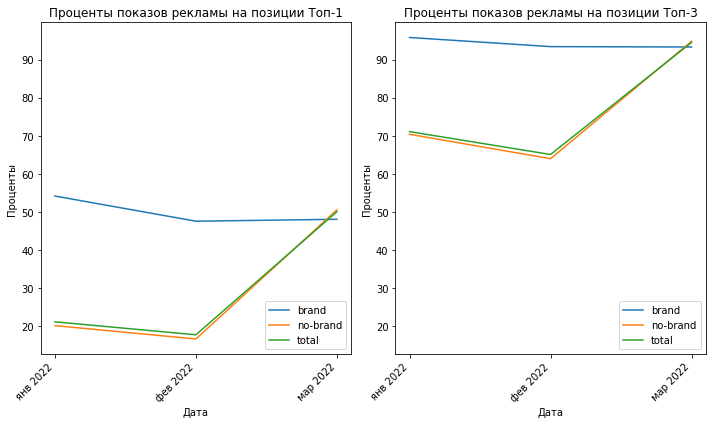

In [12]:
# строим графики

lines(data_concat, 'Дата', 'Тип_кампании')

## Вывод

Процент показов брендовой рекламы на позиции Топ-1 снизился в марте по отношению к январю на 6 пунктов, на позиции Топ-3 – на 2.1 пункта. 
Процент показов не-брендовой рекламы на позиции Топ-1 увеличился в марте по отношению к январю на 30.4 пункта, на позиции Топ-3 – на 24.4 пункта.